RL Fall 99

Homework #4 - MDP

Ali Elahi SID: 810696336

MC - On Policy

# Importing essential libraries

In [1]:
import random
import pprint
import io
import numpy as np
import sys
import numpy as np
from gym.envs.toy_text import discrete
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
import bisect
from tqdm import tqdm

In [2]:
from amalearn.environment import MutliArmedBanditEnvironment
from amalearn.environment import EnvironmentBase
from amalearn.reward import GaussianReward
from amalearn.agent import RandomBanditAgent
from amalearn.agent import AgentBase

# Utils

In [4]:
def sliding_window(x):
    returns = []
    for i in range(len(x)-20):
        returns.append(np.array(x[i:i+20]).mean())
    return returns

# Class definitions

In [5]:
actions = {
    0: 'U',
    1: 'R',
    2: 'D',
    3: 'L'
}

In [6]:
%run Environment.ipynb

In [7]:
class MC_OP_Agent(AgentBase):
    def __init__(self, id, environment, action_definition, gamma):
        super(MC_OP_Agent, self).__init__(id, environment)
        self.Q = np.zeros((100, 4))
        self.Returns = [[[] for i in range(4)] for j in range(100)]
        self.episode_num = 0
        self.policy = np.ones((100, 4)) / len(action_definition)
        self.gamma = gamma
        self.epsilon = 1
    
    def show(self):
        # print(self.Q[:10])
        # print(self.Returns)
        print(self.policy)
        # print(self.episode_num)
    
    def show_policy(self):
        for i in range(10):
            for j in range(10):
                if (i, j) in [(1,3), (4, 1), (6,2)] :
                    print("•", end = " ")
                elif (i, j) in [(3,3), (3,4), (3,5), (4,3), (5,3), (5,4)] :
                    print("█", end = " ")
                else:
                    print(actions[np.argmax(self.policy[10 * i + j])], end = " ")
            print()
        
    def update_epsilon(self, x):
        x /= 10
        return 2 ** (1 - x/40) / 2
        #return (4 - (int(x) / 120) ** 2) / 4
    
    def get_action(self, state):
        return np.random.choice(4, 1, p = self.policy[state])[0]
    
    def update_ploicy2(self):
        for ss in range(100):
            mm = abs(self.Q[ss].sum()) + 1
            sigma = np.exp(self.Q[ss] / mm).sum()
            for i in range(4):
                self.policy[ss][i] = np.exp(self.Q[ss][i] / mm) / sigma
    
    def update_ploicy(self, s, a):
        self.epsilon = self.update_epsilon(self.episode_num)
        self.policy[s] = self.epsilon / 4
        self.policy[s][a] += (1 - self.epsilon)
    
    def generate_episode(self, state = 45):
        self.environment.reset()
        terminate = False
        states_actions = []
        rewards = []
        while True:
            current = {}
            states_actions.append((state, self.get_action(state)))
            state, reward, done, info = self.environment.step(states_actions[-1][1])
            rewards.append(reward)
            if terminate:
                break
            if done:
                terminate = True
        return states_actions, rewards
    
    def take_action(self) -> (object, float, bool, object):
        self.episode_num += 1
        
        G = 0
        states_actions, rewards = self.generate_episode()
        for i in range(len(states_actions) - 1, -1, -1):
            G = self.gamma * G + rewards[i]
            if states_actions[i] not in states_actions[0:i]:
                self.Returns[states_actions[i][0]][states_actions[i][1]].append(G)
                # print(states_actions[i][0], states_actions[i][1], np.array(self.Returns[states_actions[i][0]][states_actions[i][1]]))
                self.Q[states_actions[i][0]][states_actions[i][1]] = \
                np.array(self.Returns[states_actions[i][0]][states_actions[i][1]]).mean()
                self.update_ploicy(states_actions[i][0], np.argmax(self.Q[states_actions[i][0]]))
        return G

# Runing Algorithms

In [8]:
environment = GridworldEnv()
agent = MC_OP_Agent('1', environment, actions, 1)

In [9]:
Gs = []
for i in tqdm(range(1200)):
    Gs.append(agent.take_action())

100%|██████████| 1200/1200 [00:08<00:00, 134.51it/s]


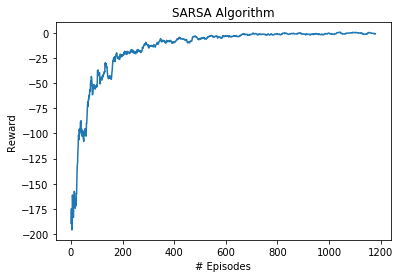

In [10]:
plt.plot(sliding_window(Gs))
plt.title('SARSA Algorithm')
plt.xlabel('# Episodes')
plt.ylabel('Reward')
plt.show()

In [11]:
agent.show_policy()

U L L L L L R U R U 
U U L • U L L R L D 
U U L L L R U D L L 
U U U █ █ █ U L D L 
U • U █ R R U U L R 
D L R █ █ R R R U D 
D L • D R R L U U U 
R R R D U R D R U U 
R R L D R R U R U D 
U D L L D U R L U D 
